# Initialisierung

In [3]:
from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from IPython.display import display, Markdown

In [4]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [5]:
app_train = pd.read_csv(DATASET_DIR / "application_train.csv")
pcb = pd.read_csv(DATASET_DIR / "POS_CASH_balance.csv")
description = pd.read_csv(DATASET_DIR / "HomeCredit_columns_description.csv", encoding="latin", index_col=0)

In [6]:
description.loc[description['Table']=="POS_CASH_balance.csv", "Row":"Special"]

,Row,Description,Special
145,SK_ID_PREV,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",NaN
146,SK_ID_CURR,ID of loan in our sample,NaN
147,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
148,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
149,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
150,NAME_CONTRACT_STATUS,Contract status during the month,NaN
151,SK_DPD,DPD (days past due) during the month of previous credit,NaN
152,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,NaN


In [7]:
# Function to draw a Piechart
def draw_piechart(arguments):
    
    fig, ax = plt.subplots(1,len(arguments))

    try:
    # Handle multiple plots
        for argument, a in zip(arguments,ax):
            labels = argument[0]
            sizes = argument[1]
            title = argument[2]

            a.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, normalize=False, labeldistance=1.05)
            a.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            a.set_title(title)
            
    # Handle single plot           
    except TypeError:
        for argument in arguments:
            labels = argument[0]
            sizes = argument[1]
            title = argument[2]
        
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, normalize=False)
            ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
            ax.set_title(title)
    plt.show()

# Datenaufbereitung

In [8]:
# Schnittmenge zwischen app_train und bureau
# Ergänzt die Variable "TARGET" in dem bureau-Datensatz
pcb = pd.merge(pcb, app_train[["SK_ID_CURR","TARGET"]] ,on="SK_ID_CURR")

# Austausch der numerischen Kategorien durch sprechende, interpretierbare Variablen
pcb["TARGET"].replace(
    {
        0: "Payback",
        1: "Default"
    }, inplace = True
)

# Unterteilung des Datensatzen nach Payback und Default
payback = pcb[pcb["TARGET"] == "Payback"]
default = pcb[pcb["TARGET"] == "Default"]

In [10]:
skip = ["SK_ID_PREV", "SK_ID_CURR", "TARGET"]

n_heads = [element for element in pcb.columns if pcb[element].dtype.name == "object"]
n_heads = [element for element in n_heads if element not in skip]
n_heads += ["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"]

m_heads = [element for element in pcb.columns if pcb[element].dtype.name != "object"]
m_heads = [element for element in m_heads if element not in skip]
m_heads = [element for element in m_heads if element not in n_heads]


n = pcb[n_heads]
m = pcb[m_heads]

In [11]:
n.head()

,NAME_CONTRACT_STATUS,CNT_INSTALMENT
0,Active,48.0
1,Active,48.0
2,Active,48.0
3,Active,48.0
4,Active,48.0


In [12]:
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,TARGET
0,1803195,182943,-31,48.0,45.0,Active,0,0,Payback
1,1803195,182943,-17,48.0,31.0,Active,0,0,Payback
2,1803195,182943,-21,48.0,35.0,Active,0,0,Payback
3,1803195,182943,-8,48.0,21.0,Active,0,0,Payback
4,1803195,182943,-4,48.0,17.0,Active,0,0,Payback


# Datenanalyse

In [13]:
imp = ['CNT_PAYMENT_0.0', 'CODE_GENDER', 'CREDIT_DAY_OVERDUE_0.0',
       'DAYS_BIRTH', 'DAYS_CREDIT_1.0', 'DAYS_FIRST_DRAWING_0.75',
       'DAYS_LAST_DUE_1ST_VERSION_1.0', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'FLAG_DOCUMENT_3', 'MAX_AMTDIFF', 'MEAN_AMTDIFF',
       'MEAN_TIMEDIFF', 'NAME_YIELD_GROUP low_normal',
       'ORGANIZATION_TYPE',
       'PRODUCT_COMBINATION POS industry with interest', 'SUM_DPD']

In [14]:
for head in m_heads:
    for head2 in imp:
        if head in head2:
            print(head)

## kategorische Variablen

In [15]:
result = {
    "head" : [],
    "cat" : [],
    "payback" : [],
    "default" : [],
    "diff" : []
}

for head in n.columns.values:
    df1 = payback[head].value_counts().rename_axis(head).reset_index(name='payback').head()
    df2 = default[head].value_counts().rename_axis(head).reset_index(name='default').head()
    
    df1["payback"] = df1["payback"]/df1["payback"].sum()*100
    df2["default"] = df2["default"]/df2["default"].sum()*100
    
    df = df1.merge(df2, how="outer", on=head)
    
    df["diff"] = (df["default"]-df["payback"])
    
    df = df.sort_values("diff", ascending=False)
    
    for diff in df["diff"]:
        if np.isnan(diff):
            continue
        if diff > 5 or diff < -5:
            row = df.loc[df["diff"] == diff]
            cat = row[head][row[head].index[0]]
            
            result["head"].append(head)
            result["cat"].append(cat)
            result["payback"].append(round(row["payback"].values[0],2))
            result["default"].append(round(row["default"].values[0],2))
            result["diff"].append(round(diff,2))

df = pd.DataFrame(result)
df.sort_values("diff", ascending=False)

,head,cat,payback,default,diff


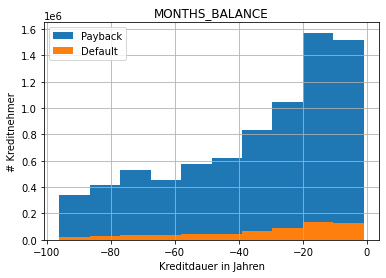

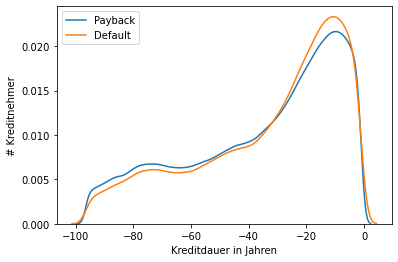

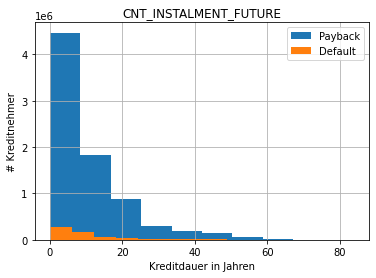

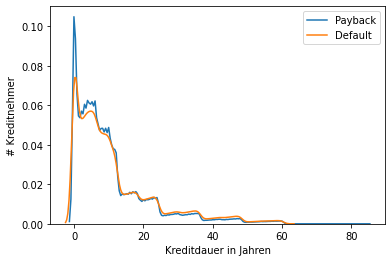

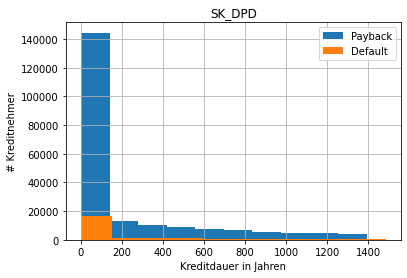

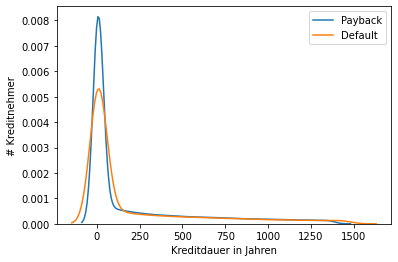

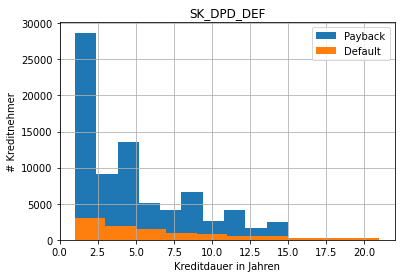

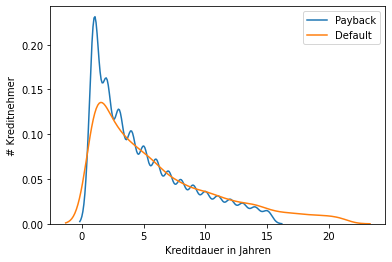

In [35]:
for head in m_heads:

    pb = payback[head].copy()
    df = default[head].copy()
    
    if head in ["SK_DPD", "SK_DPD_DEF"]:
        pb = pb[pb > 0]
        df = df[df > 0]
        
        pb = pb[pb < pb.quantile(0.9)]
        df = df[df < df.quantile(0.9)]

    pb.hist()
    df.hist()

    plt.title(head)
    plt.legend(labels=["Payback","Default"])
    plt.xlabel("Kreditdauer in Jahren")
    plt.ylabel("# Kreditnehmer")
    plt.show()

    sns.kdeplot(pb).get_lines()[0].get_data()
    sns.kdeplot(df).get_lines()[1].get_data()

    plt.legend(labels=["Payback","Default"])
    plt.xlabel("Kreditdauer in Jahren")
    plt.ylabel("# Kreditnehmer")
    plt.show()